In [7]:
import rioxarray as rxr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap
import psutil
import os

In [8]:
min_intersection_area = 150 #sq meters
orb_features = 2000
min_matches = 4
matches_dist_coef = 0.65
checkpoint = False


In [9]:

i=0
def print_memory(m=""):
    global i
    print(f"Memory {i} {m}: {psutil.Process(os.getpid()).memory_info().rss/1024**2:.2f} MB")
    
    i+=1

In [10]:
global matches

In [11]:
class MatchFailedError(Exception):
    pass

def get_common_parts(src_arr, dst_arr):
    """ Get common parts of two arrays using image stitching (https://github.com/sachin-vs/UAV-Image-stitching) """
    src_arr_norm = cv2.normalize(src_arr, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    dst_arr_norm = cv2.normalize(dst_arr, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    orb = cv2.ORB_create(nfeatures=orb_features)
    src_keypoints, src_descriptors = orb.detectAndCompute(src_arr_norm, None)
    dst_keypoints, dst_descriptors = orb.detectAndCompute(dst_arr_norm, None)
    bf = cv2.BFMatcher()#cv2.BFMatcher_create(cv2.NORM_HAMMING)
    global matches
    matches = bf.knnMatch(src_descriptors, dst_descriptors,k=2)
    matches = [m for m, n in matches if m.distance < matches_dist_coef * n.distance]
    if len(matches) < min_matches:
        raise MatchFailedError(f"Not enough matches ({len(matches)} < {min_matches})")
    global src_pts
    global dst_pts
    src_pts = np.float32([ src_keypoints[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([ dst_keypoints[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    if H is None:
        raise MatchFailedError(f"Homography is None")
    src_rows, src_cols = src_arr.shape[:2]
    dst_rows, dst_cols = dst_arr.shape[:2]

    src_points = np.float32([[0,0], [0,src_rows], [src_cols,src_rows], [src_cols,0]]).reshape(-1,1,2)

    src_points = cv2.perspectiveTransform(src_points, H)
    dst_points = np.float32([[0,0], [0, dst_rows],[dst_cols, dst_rows], [dst_cols, 0]]).reshape(-1, 1, 2)

    list_of_points = np.concatenate((src_points, dst_points), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
    if abs(x_min) > max(src_cols, dst_cols) or abs(y_min) > max(src_rows, dst_rows) or abs(x_max) > max(src_cols, dst_cols) or abs(y_max) > max(src_rows, dst_rows):
        raise MatchFailedError(f"Too big offset ({x_min}, {y_min}, {x_max}, {y_max})")
    translation_dist = [-x_min,-y_min]
    
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    
    src_common = cv2.warpPerspective(src_arr, H_translation.dot(H), (x_max-x_min, y_max-y_min), borderValue=np.nan)

    src_mask = np.isnan(src_common)
    
    dst_common = np.empty(src_common.shape, np.float32)
    dst_common[:] = np.nan
    dst_common[translation_dist[1]:dst_rows+translation_dist[1], translation_dist[0]:dst_cols+translation_dist[0]] = dst_arr
    dst_mask = np.isnan(dst_common)
    
    mask = src_mask | dst_mask
    dst_common[mask] = np.nan
    src_common[mask] = np.nan
    return src_common, dst_common
    
def get_offset(src_arr, dst_arr):
    diff =(src_arr-dst_arr)
    mean = np.nanmean(diff)
    std = np.nanstd(diff.flatten())
    return mean, 1./std

In [12]:
tiff_cal_dir = "data/output/tiff_cal"
tiff_dir = "data/output/tiff"
geotiff_dir = "data/output/geotiff"

In [13]:
src_name = "DJI_20220324154305_0287_T.JPG.tiff"
dst_name = "DJI_20220324153632_0158_T.JPG.tiff"
src_raster = rxr.open_rasterio(f"{tiff_cal_dir}/{src_name}")
dst_raster = rxr.open_rasterio(f"{tiff_dir}/{dst_name}")
src_arr = src_raster.values.squeeze()
dst_arr = dst_raster.values.squeeze()

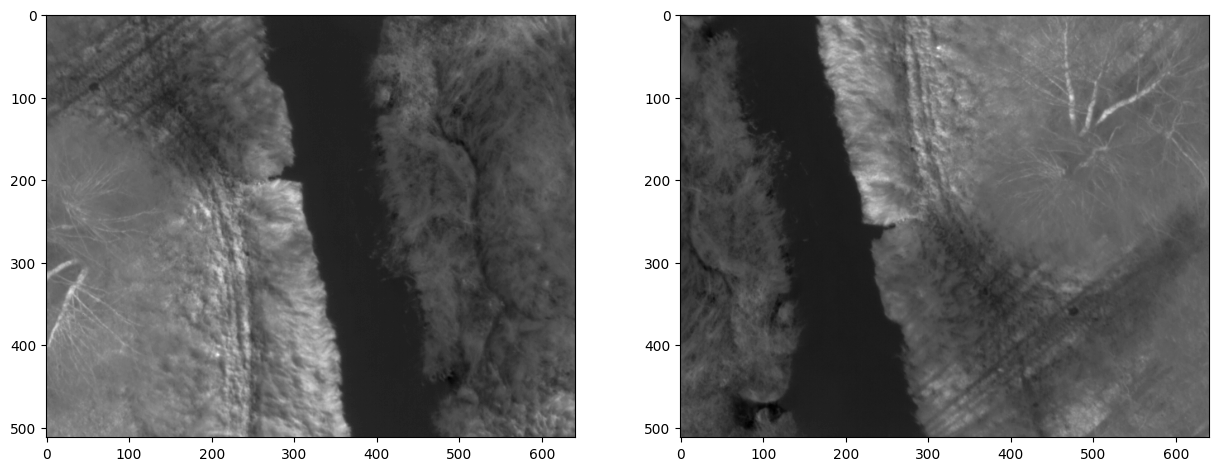

In [14]:

#plot src_raster and dst_raster on two subplots (keep image aspect ratio)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(src_arr, cmap="gray")
ax2.imshow(dst_arr, cmap="gray")
plt.show()  

In [15]:
# #open data/output/footprints.geojson
# footprints = gpd.read_file("data/output/footprints.geojson")
# #get footprints of where names are src_name or dst_name
# src_footprint = footprints[footprints["name"] == src_name]
# dst_footprint = footprints[footprints["name"] == dst_name]
# m = leafmap.Map()
# # m.add_gdf(src_footprint, layer_name="src")
# # m.add_gdf(dst_footprint, layer_name="dst")
# m.add_raster(f"{geotiff_dir}/{src_name}", layer_name="src")
# m.add_raster(f"{geotiff_dir}/{dst_name}", layer_name="dst")
# m

In [16]:
src_clip, dst_clip = get_common_parts(src_raster[0].values, dst_raster[0].values)

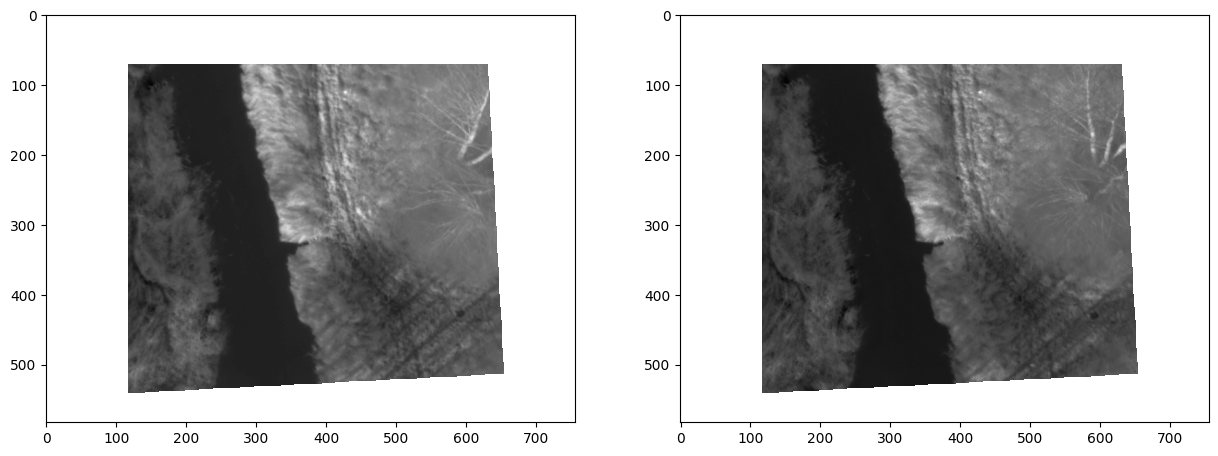

In [17]:
#plot src_clip and dst_clip on two subplots (keep image aspect ratio)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(src_clip, cmap="gray")
ax2.imshow(dst_clip, cmap="gray")